#660710252 วริศราภรณ์ กันชัยต๊ะ

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [ ]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [ ]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [ ]:
# DataFrame for the count of each coffee item sold per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [ ]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

,date,total_sales
0,2023-03-01,8645
1,2023-03-02,8560
2,2023-03-03,8690
3,2023-03-04,4365
4,2023-03-05,4565


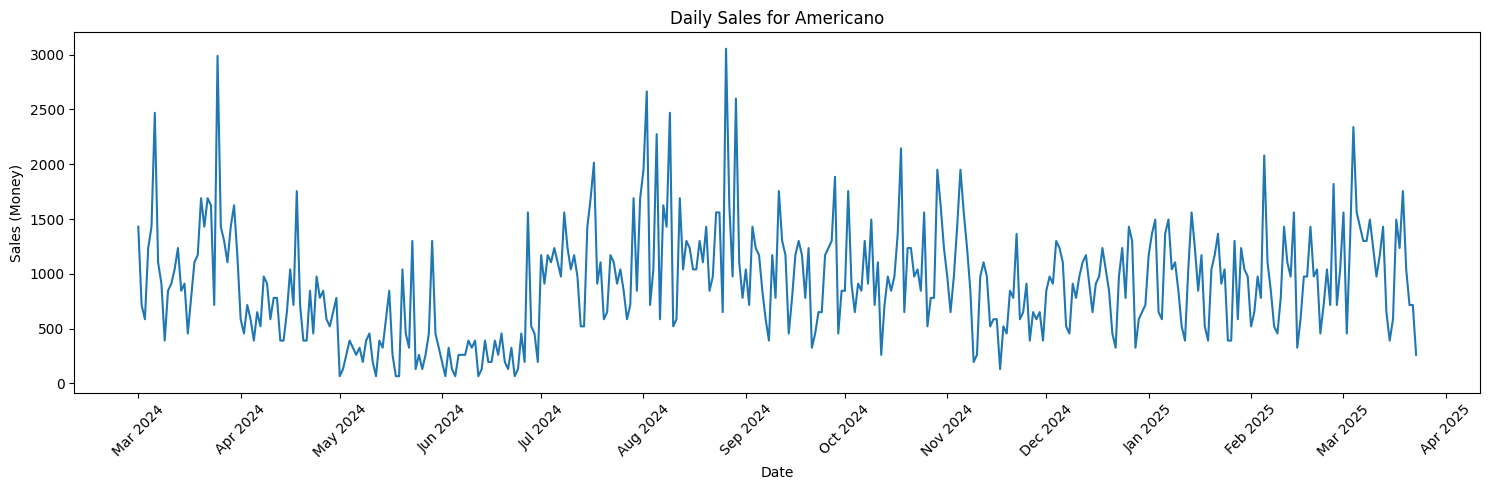

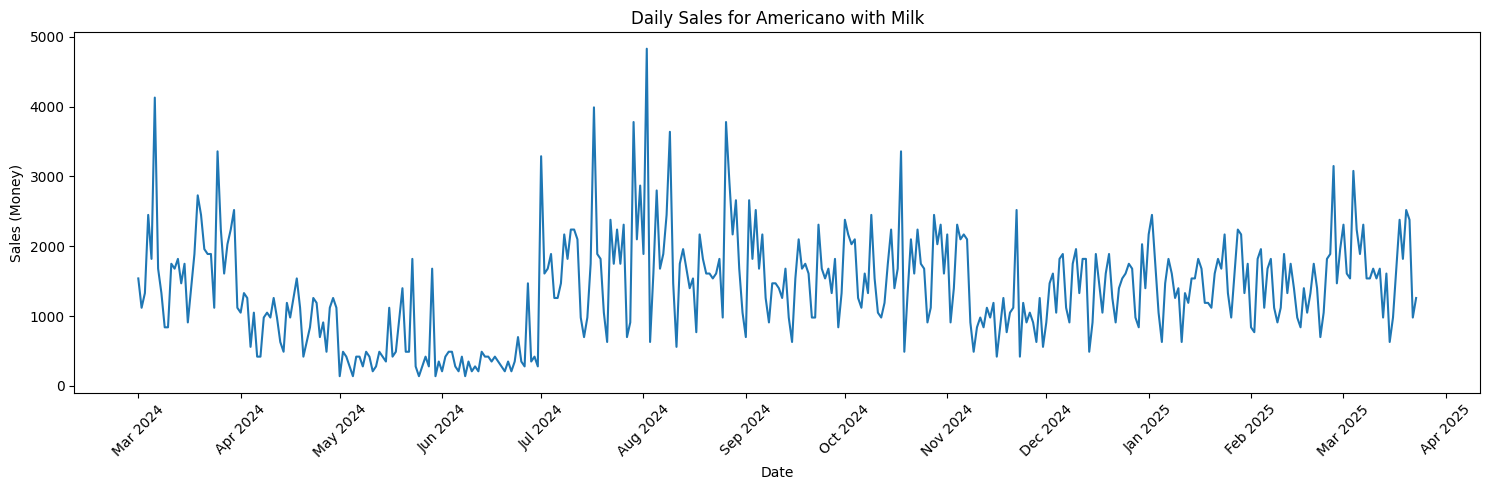

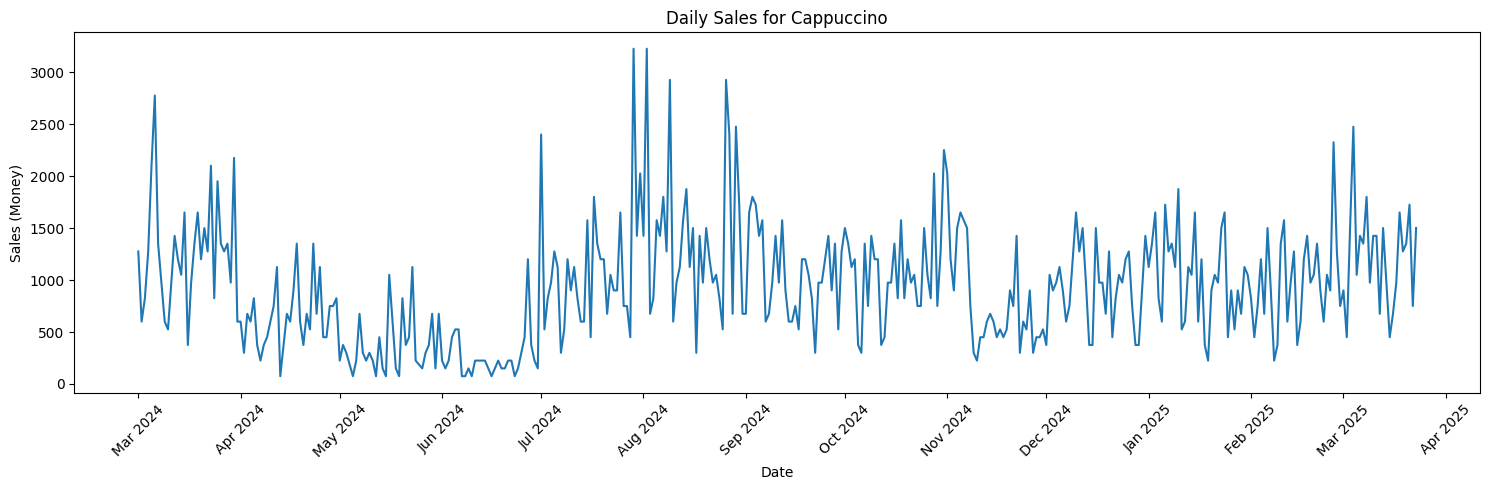

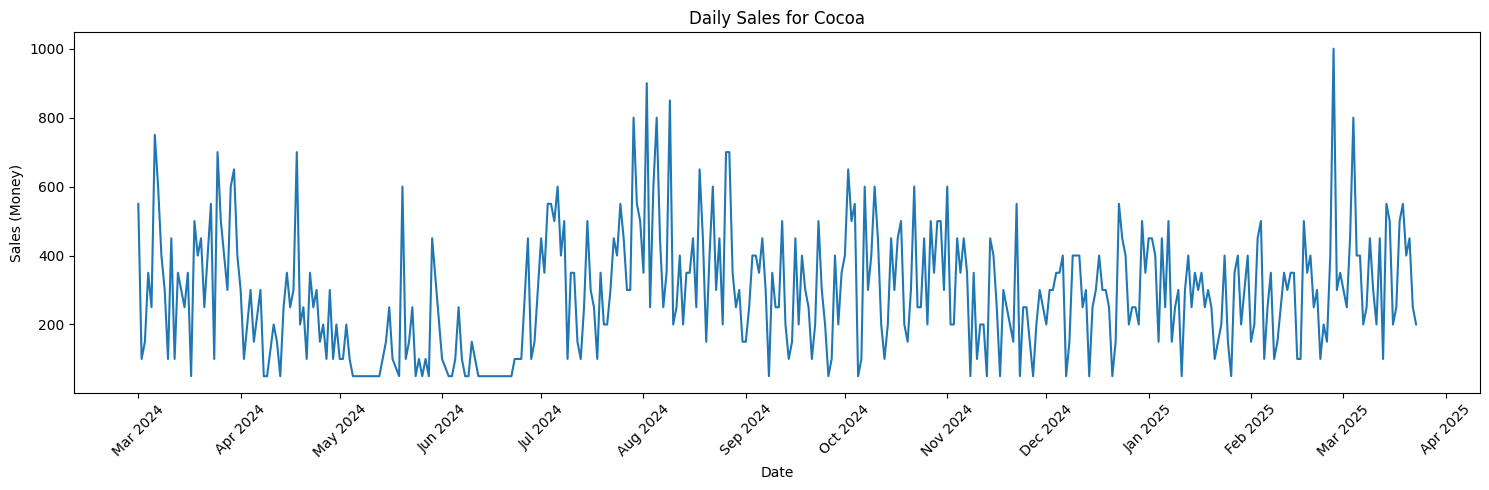

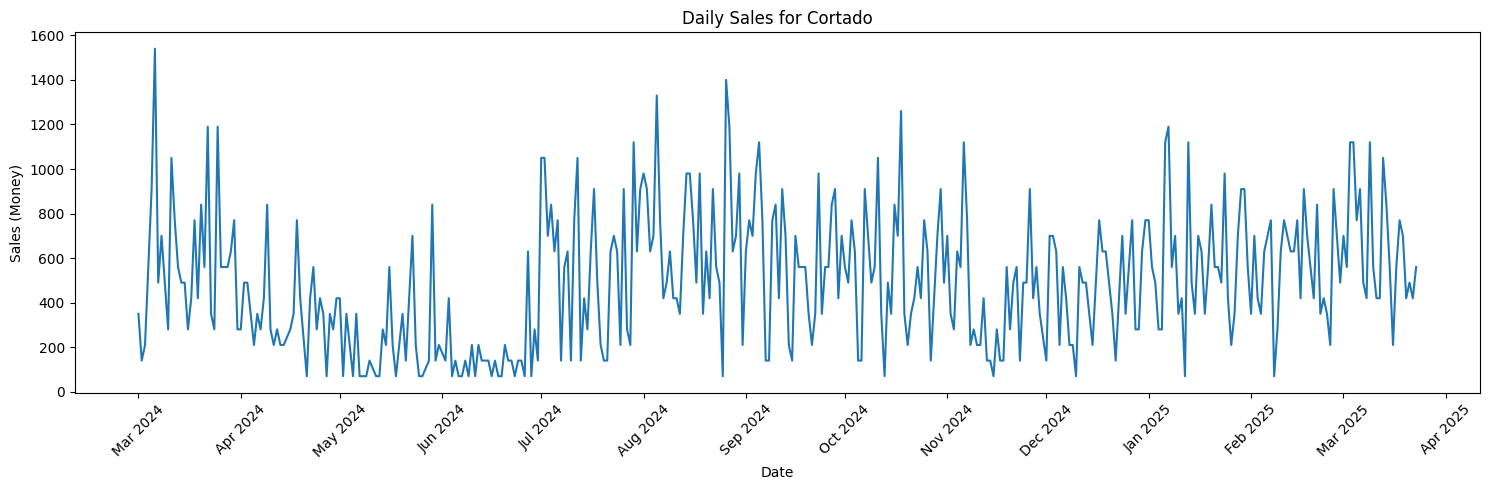

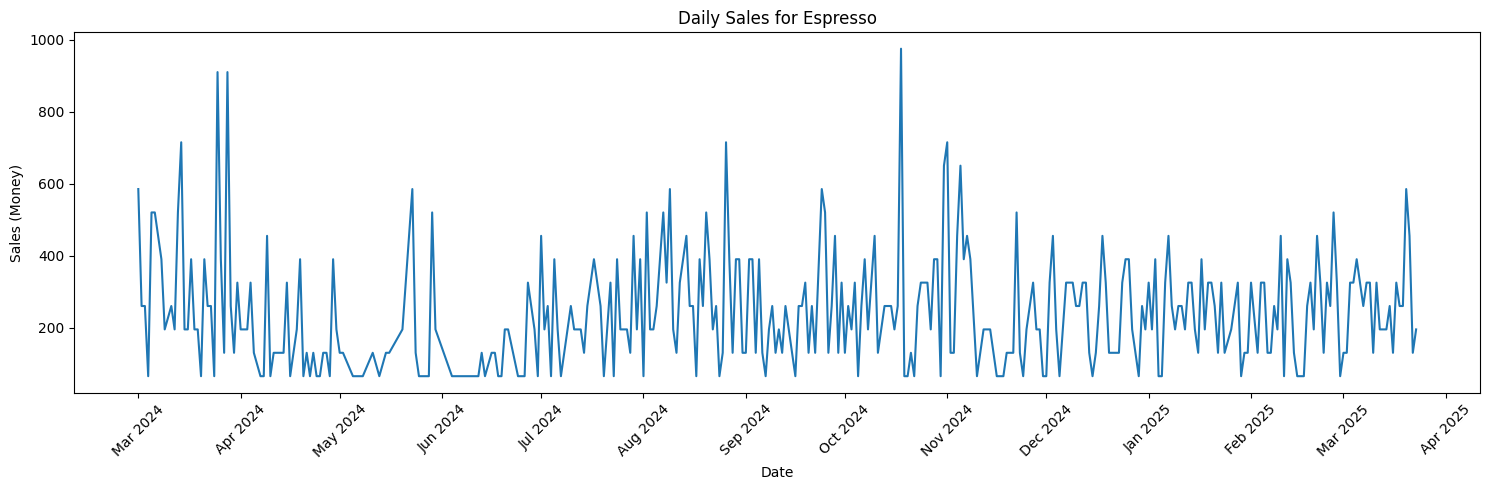

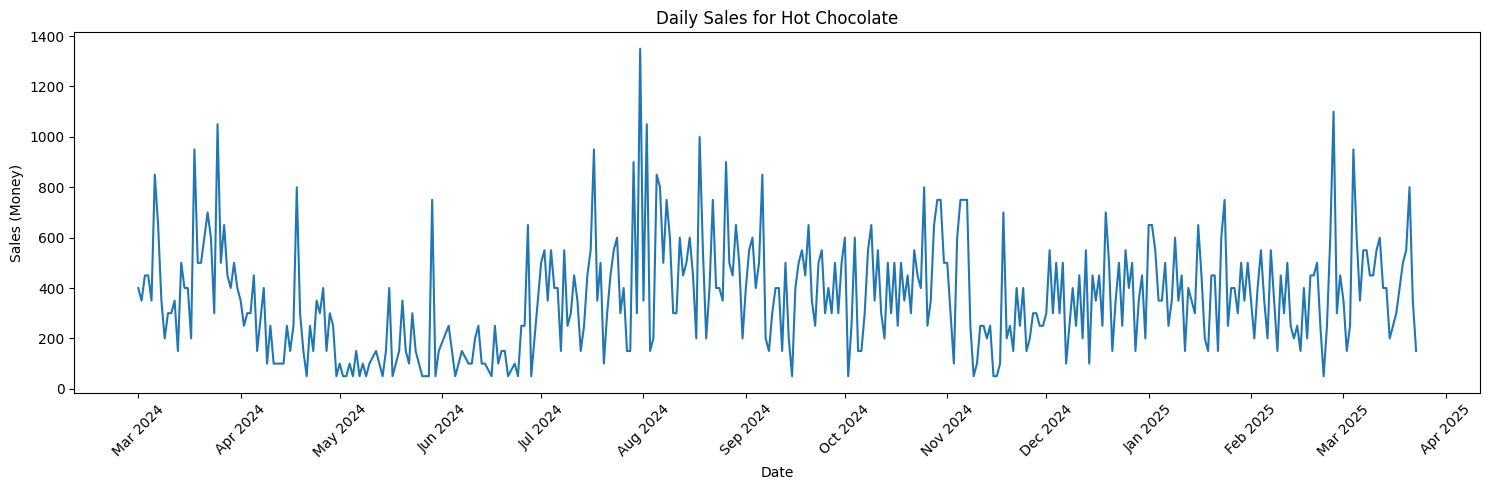

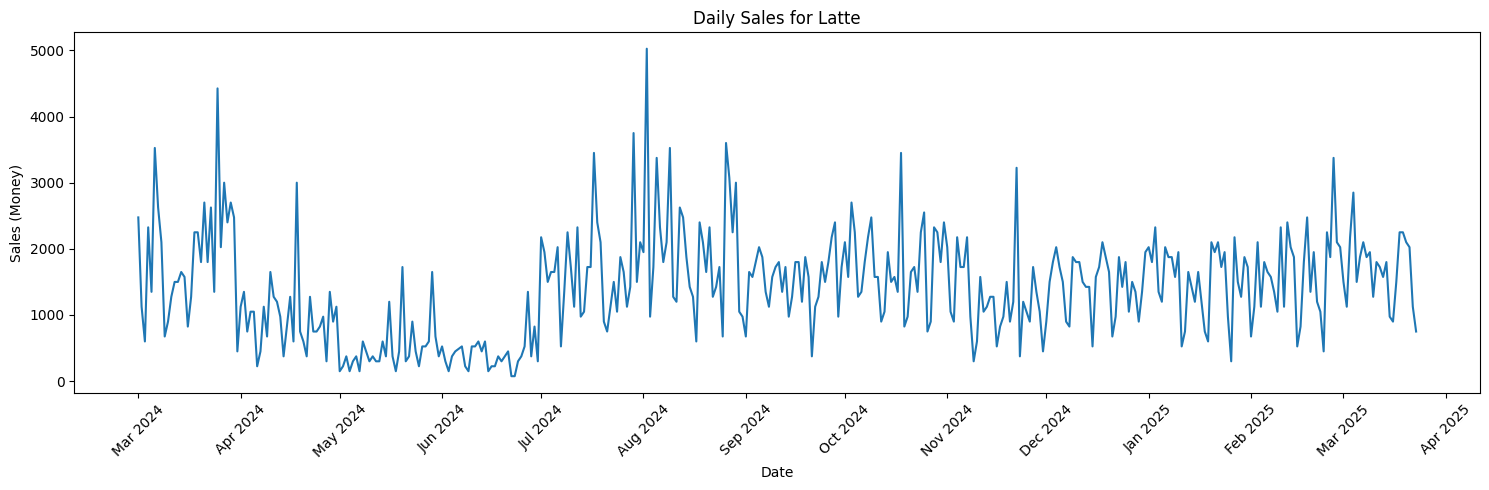

In [ ]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_total_sales_features = create_sales_features(daily_total_sales.copy())


# Drop rows with NaN values created by lag features
daily_total_sales_features.dropna(inplace=True)

display(daily_total_sales_features.head())

,date,total_sales,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,7200,2,1,3,74,2023,7290.0,8645.0,6460.000000
15,2023-03-16,7315,3,1,3,75,2023,7140.0,8560.0,6447.142857
16,2023-03-17,7510,4,1,3,76,2023,7120.0,8690.0,6472.142857
17,2023-03-18,5250,5,1,3,77,2023,5735.0,4365.0,6527.857143
18,2023-03-19,4765,6,1,3,78,2023,3635.0,4565.0,6458.571429


In [ ]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [ ]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'

In [ ]:
X = daily_total_sales_features[FEATURES]
y = daily_total_sales_features[TARGET]

In [ ]:
# Determine the split date
split_date = '2025-03-01'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [ ]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [ ]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [ ]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 1128.13 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 1035.21 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 366330.00 บาท


In [ ]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

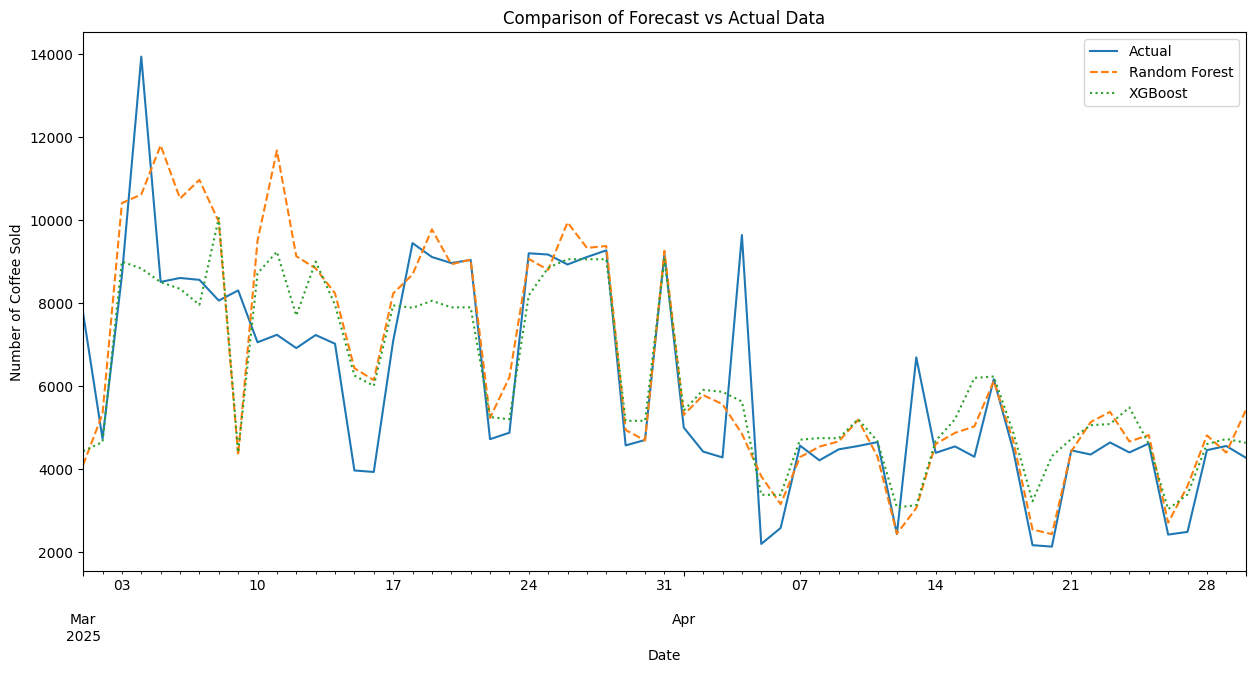

In [ ]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

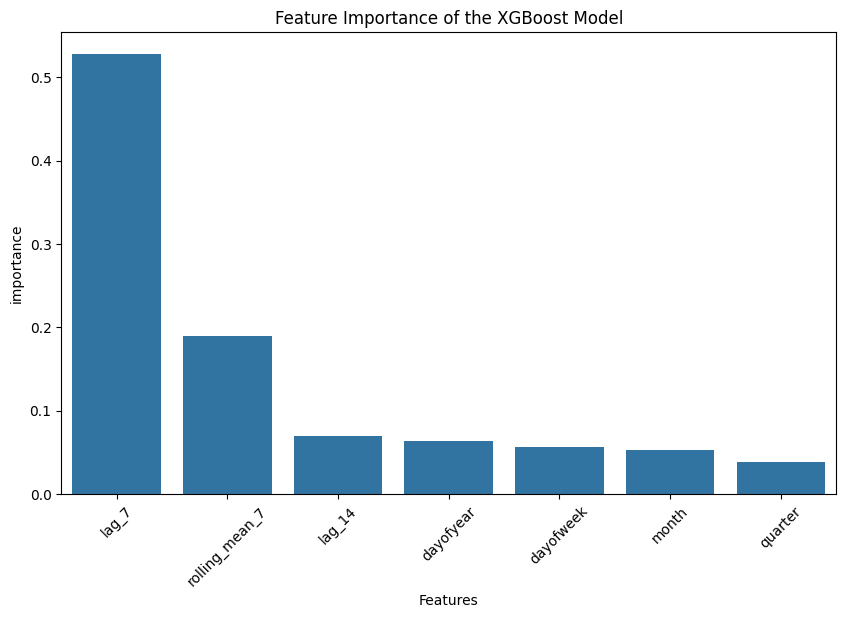

In [ ]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

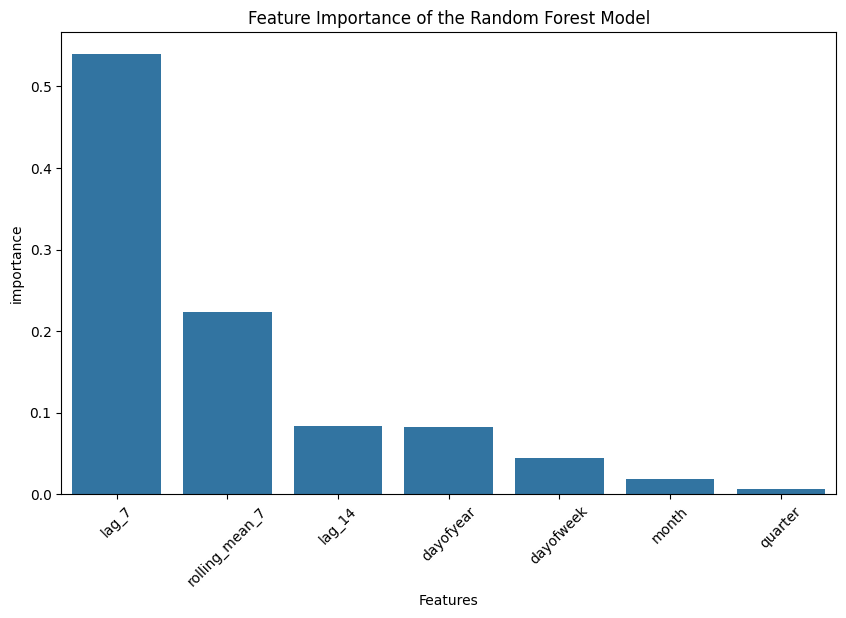

In [ ]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

ใช้ prophet

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [ ]:
prophet_train = train_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})
prophet_test = test_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Prophet requires a continuous time series without missing dates.
# It's generally recommended to ensure the data has a daily frequency and fill missing dates if necessary.
# For simplicity now, we'll use the data as is, but note this for potential issues.
# If there are missing dates, Prophet can handle them to some extent but performance might be affected.

In [ ]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaazz3g58/4pgmdkbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaazz3g58/iveebeux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13999', 'data', 'file=/tmp/tmpaazz3g58/4pgmdkbb.json', 'init=/tmp/tmpaazz3g58/iveebeux.json', 'output', 'file=/tmp/tmpaazz3g58/prophet_model0g9s7mtw/prophet_model-20250921123443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744,
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
       773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791],
      dtype='int64')

In [ ]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [ ]:
# Make predictions
forecast = model.predict(future)

In [ ]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-15,9233.730622,6862.805758,11586.093580
1,2023-03-16,9251.532056,6957.361127,11674.414008
2,2023-03-17,8906.581304,6429.143415,11243.670700
3,2023-03-18,5968.444038,3491.590086,8235.222232
4,2023-03-19,6036.730926,3617.921258,8475.558274


In [ ]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [ ]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.2f} บาท")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 1180.71 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set (สำหรับ Prophet): 366330.00 บาท


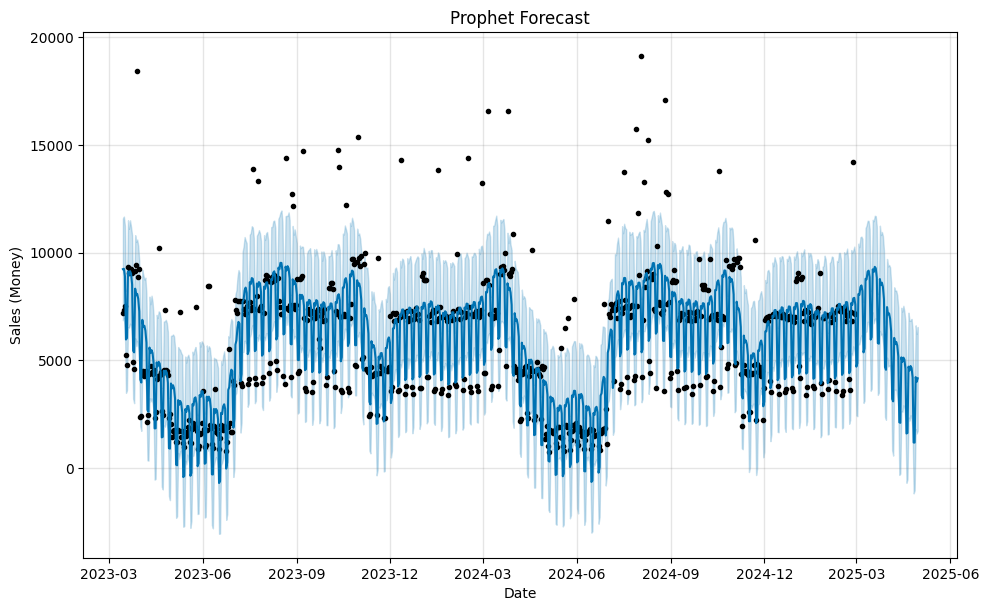

In [ ]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

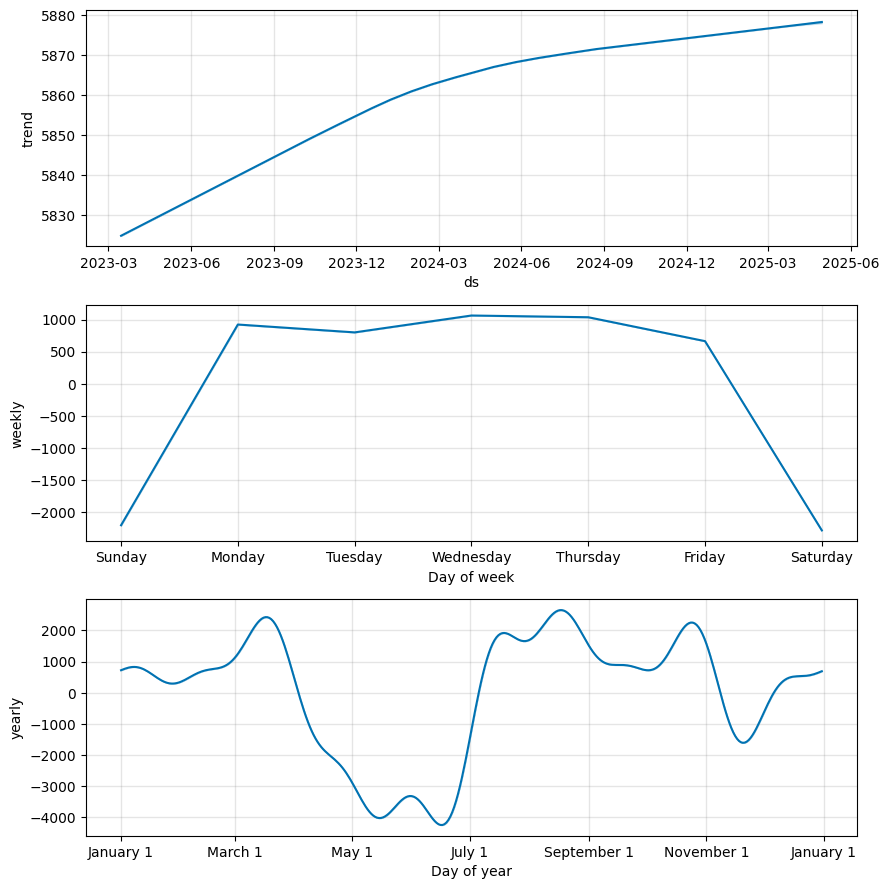

In [ ]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-5seb870g
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-5seb870g
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

In [ ]:
coffee_forecasts = {}
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]
    # Convert the 'total_sales' column from the filtered data to a torch tensor
    context = torch.tensor(coffee_sales['money'].values)

    # Define the prediction length (e.g., 60 days for one month forecast)
    prediction_length = 60

    # Make a forecast using the Chronos pipeline
    forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
    median_prediction = forecast[0].median(dim=0).values

    coffee_forecasts[coffee_name] = median_prediction

# Display the median prediction
    print(f"Chronos Median Forecast for the next {prediction_length} days:")
    display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([ 976.7506, 1103.8619, 1103.8619, 1103.8619, 1036.9612,  648.9371,
         521.8256,  976.7506, 1036.9612, 1036.9612, 1170.7627,  909.8499,
         454.9249,  454.9249,  842.9492,  976.7506,  842.9492,  909.8499,
         582.0363,  388.0242,  454.9249,  648.9371,  842.9492,  976.7506,
         782.7385,  521.8256,  388.0242,  260.9128,  521.8256,  648.9371,
         521.8256,  521.8256,  454.9249,  260.9128,  388.0242,  521.8256,
         715.8378,  454.9249,  521.8256,  388.0242,  327.8136,  260.9128,
         454.9249,  454.9249,  327.8136,  327.8136,  327.8136,  194.0121,
         260.9128,  327.8136,  388.0242,  454.9249,  388.0242,  327.8136,
         260.9128,  127.1114,  260.9128,  521.8256,  327.8136,  327.8136])

Chronos Median Forecast for the next 60 days:


tensor([1818.0166, 1818.0166, 1818.0166, 1675.8253, 1472.6949, 1046.1212,
         842.9909, 1472.6949, 1746.9209, 1543.7905, 1543.7905, 1330.5038,
         771.8953,  975.0256, 1533.6340, 1401.5992, 1472.6949, 1330.5038,
        1401.5992,  629.7040,  842.9909, 1401.5992, 1472.6949, 1259.4081,
        1188.3125,  975.0256,  487.5128,  771.8953, 1046.1212,  975.0256,
        1117.2168,  975.0256,  914.0865,  487.5128,  629.7040,  914.0865,
         975.0256,  914.0865,  842.9909,  700.7996,  558.6084,  629.7040,
         914.0865,  842.9909,  842.9909,  914.0865,  629.7040,  487.5128,
         629.7040,  700.7996,  914.0865,  700.7996,  914.0865,  487.5128,
         487.5128,  558.6084,  700.7996,  975.0256,  771.8953,  914.0865])

Chronos Median Forecast for the next 60 days:


tensor([1350.3767, 1350.3767, 1426.1631, 1350.3767, 1123.0175,  675.1884,
         826.7612, 1501.9496, 1426.1631, 1426.1631, 1198.8038,  750.9748,
         523.6155,  826.7612, 1123.0175, 1274.5903, 1047.2310,  902.5477,
         599.4019,  303.1458,  599.4019,  971.4445,  902.5477, 1198.8038,
         750.9748,  599.4019,  523.6155,  523.6155,  826.7612,  750.9748,
         826.7612,  750.9748,  523.6155,  372.0426,  599.4019,  675.1884,
         902.5477,  826.7612,  675.1884,  523.6155,  358.2632,  447.8290,
         544.2845,  750.9748,  750.9748,  599.4019,  461.6084,  372.0426,
         447.8290,  599.4019,  750.9748,  599.4019,  447.8290,  372.0426,
         372.0426,  523.6155,  523.6155,  640.7400,  599.4019,  564.9536])

Chronos Median Forecast for the next 60 days:


tensor([299.5713, 299.5713, 349.1407, 299.5713, 250.0020, 150.8633, 349.1407,
        349.1407, 299.5713, 299.5713, 299.5713, 250.0020, 250.0020, 299.5713,
        349.1407, 349.1407, 299.5713, 250.0020, 299.5713, 250.0020, 250.0020,
        299.5713, 299.5713, 250.0020, 299.5713, 250.0020, 150.8633, 200.4326,
        250.0020, 299.5713, 299.5713, 200.4326, 150.8633, 200.4326, 250.0020,
        250.0020, 200.4326, 150.8633, 200.4326, 250.0020, 200.4326, 299.5713,
        250.0020, 250.0020, 250.0020, 250.0020, 250.0020, 150.8633, 150.8633,
        200.4326, 150.8633, 250.0020, 150.8633, 150.8633, 150.8633, 250.0020,
        200.4326, 200.4326, 250.0020, 299.5713])

Chronos Median Forecast for the next 60 days:


tensor([453.1987, 420.3052, 489.7469, 420.3052, 420.3052, 420.3052, 420.3052,
        420.3052, 559.1887, 559.1887, 350.8635, 628.6304, 420.3052, 489.7469,
        489.7469, 281.4218, 420.3052, 350.8635, 281.4218, 281.4218, 420.3052,
        350.8635, 420.3052, 420.3052, 420.3052, 281.4218, 211.9800, 420.3052,
        208.3252, 211.9800, 281.4218, 281.4218, 489.7469, 420.3052, 208.3252,
        281.4218, 281.4218, 350.8635, 350.8635, 281.4218, 277.7669, 281.4218,
        350.8635, 420.3052, 211.9800, 281.4218, 281.4218, 350.8635, 420.3052,
        350.8635, 350.8635, 350.8635, 208.3252, 489.7469, 281.4218, 281.4218,
        350.8635, 350.8635, 350.8635, 420.3052])

Chronos Median Forecast for the next 60 days:


tensor([259.7318, 194.3571, 259.7318, 259.7318, 325.1065, 194.3571, 259.7318,
        325.1065, 325.1065, 259.7318, 259.7318, 325.1065, 259.7318, 259.7318,
        259.7318, 194.3571, 259.7318, 194.3571, 194.3571, 194.3571, 194.3571,
        134.2831, 130.7494, 130.7494, 130.7494, 130.7494, 194.3571, 130.7494,
        194.3571, 130.7494, 194.3571, 194.3571, 130.7494, 130.7494, 130.7494,
        194.3571, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494,
        130.7494, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494,
        194.3571, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494, 130.7494,
        130.7494, 194.3571, 194.3571, 130.7494])

Chronos Median Forecast for the next 60 days:


tensor([299.4460, 350.2450, 401.0439, 401.0439, 299.4460, 299.4460, 350.2450,
        401.0439, 299.4460, 350.2450, 401.0439, 299.4460, 299.4460, 251.3208,
        299.4460, 251.3208, 200.5219, 350.2450, 299.4460, 200.5219, 251.3208,
        251.3208, 299.4460, 200.5219, 299.4460, 251.3208, 200.5219, 299.4460,
        251.3208, 251.3208, 299.4460, 149.7230, 299.4460, 200.5219, 251.3208,
        200.5219, 200.5219, 149.7230, 149.7230, 149.7230, 149.7230, 149.7230,
        251.3208, 149.7230, 149.7230, 200.5219, 251.3208, 149.7230, 251.3208,
        200.5219, 149.7230, 149.7230, 200.5219, 200.5219, 149.7230, 200.5219,
        251.3208, 149.7230, 200.5219, 149.7230])

Chronos Median Forecast for the next 60 days:


tensor([1871.6583, 1799.2736, 1499.3948, 1726.8892, 1427.0101,  827.2523,
         827.2523, 1499.3948, 1427.0101, 1571.7793, 1499.3948, 1199.5157,
         827.2523,  672.1425, 1271.9004, 1354.6256, 1354.6256, 1199.5157,
        1199.5157,  754.8677,  527.3733, 1354.6256, 1354.6256, 1054.7466,
        1354.6256, 1054.7466,  527.3733,  599.7579,  972.0214, 1199.5157,
        1054.7466, 1127.1312,  827.2523,  599.7579,  527.3733,  827.2523,
         899.6368, 1127.1312, 1127.1312,  672.1425,  454.9888,  454.9888,
         672.1425,  827.2523, 1054.7466,  899.6368,  744.5271,  599.7579,
         527.3733,  672.1425,  827.2523,  672.1425,  672.1425,  754.8677,
         372.2635,  599.7579,  599.7579,  972.0214,  754.8677,  827.2523])

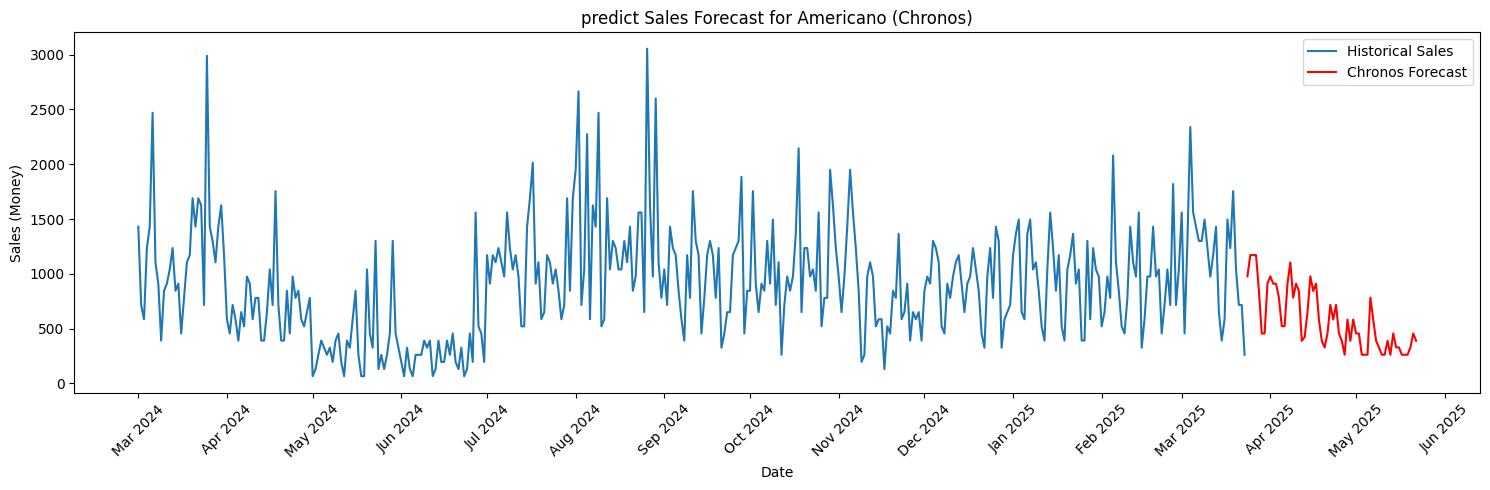

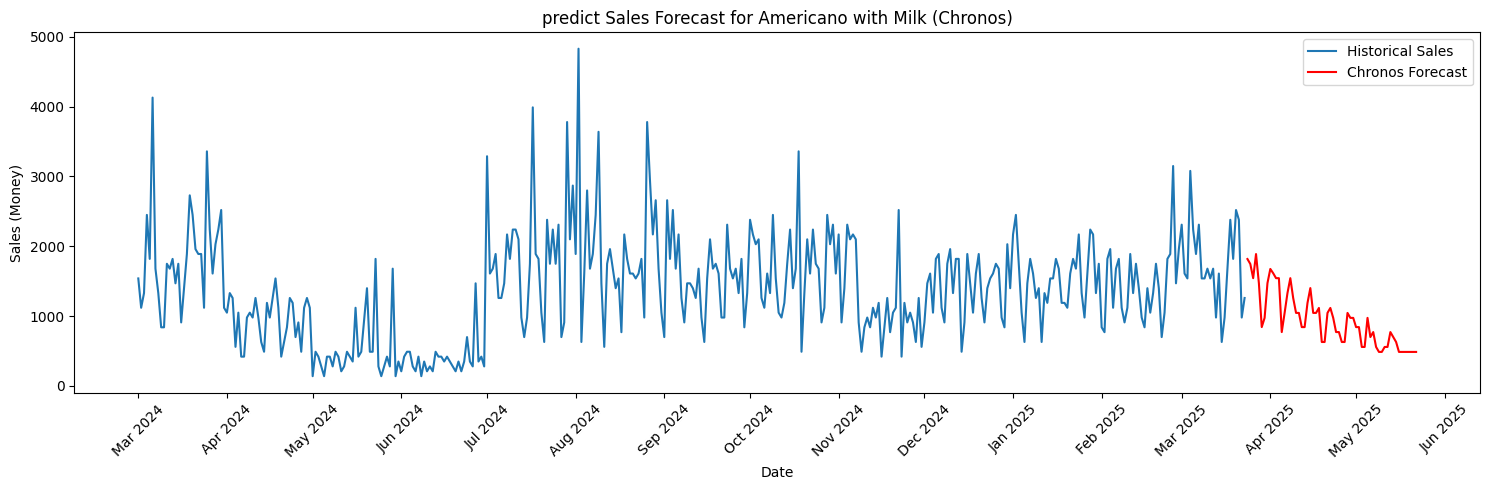

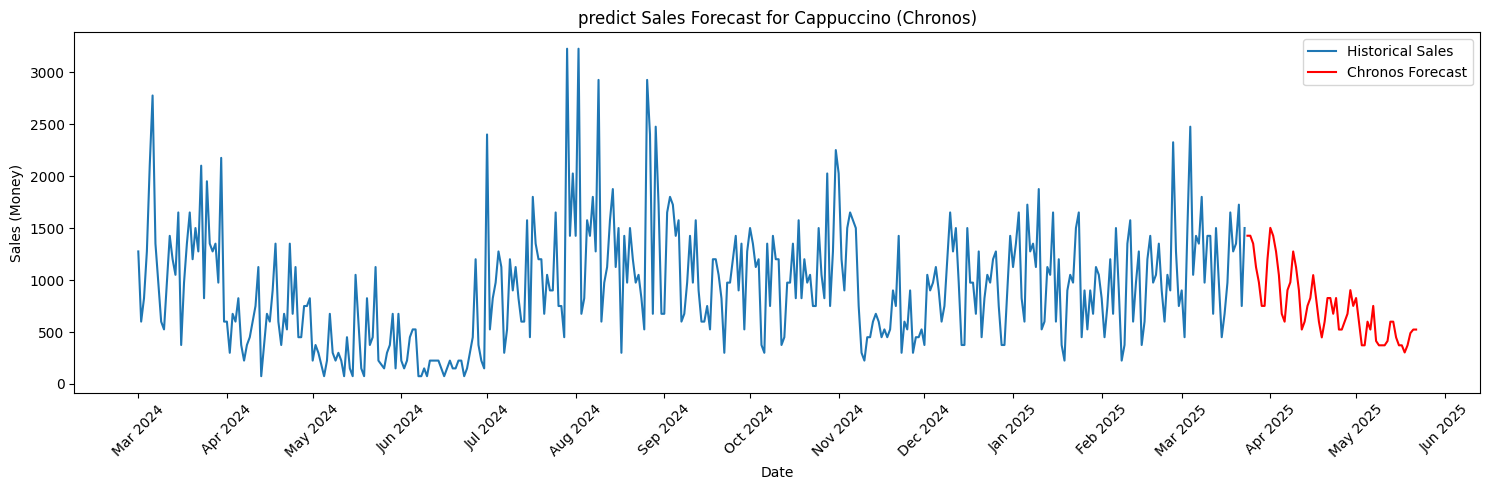

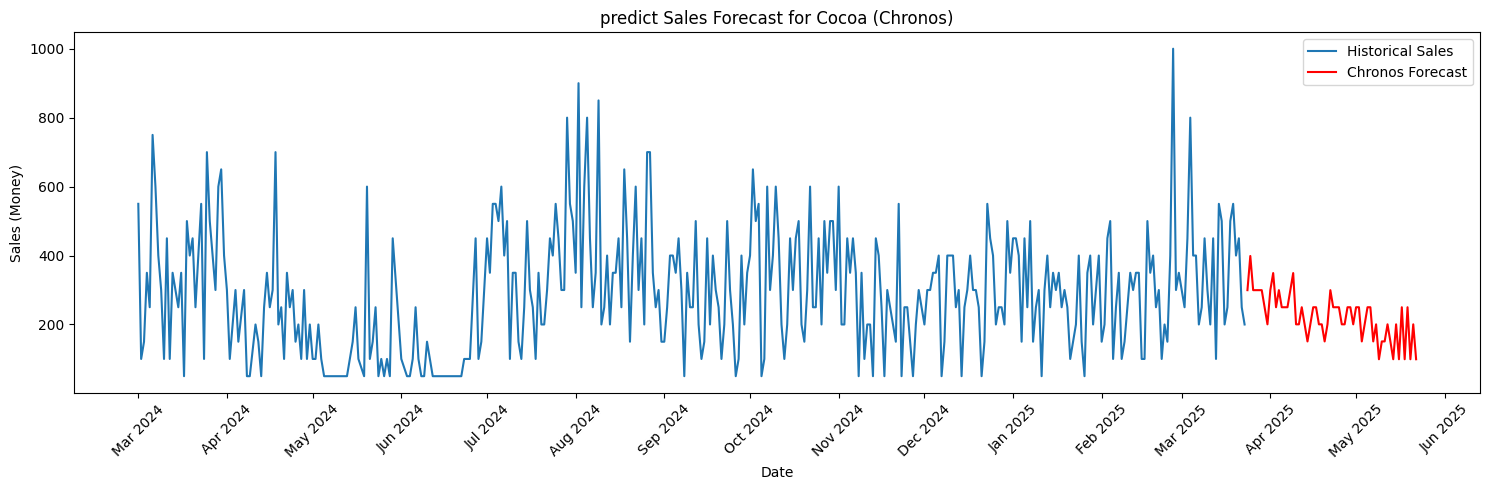

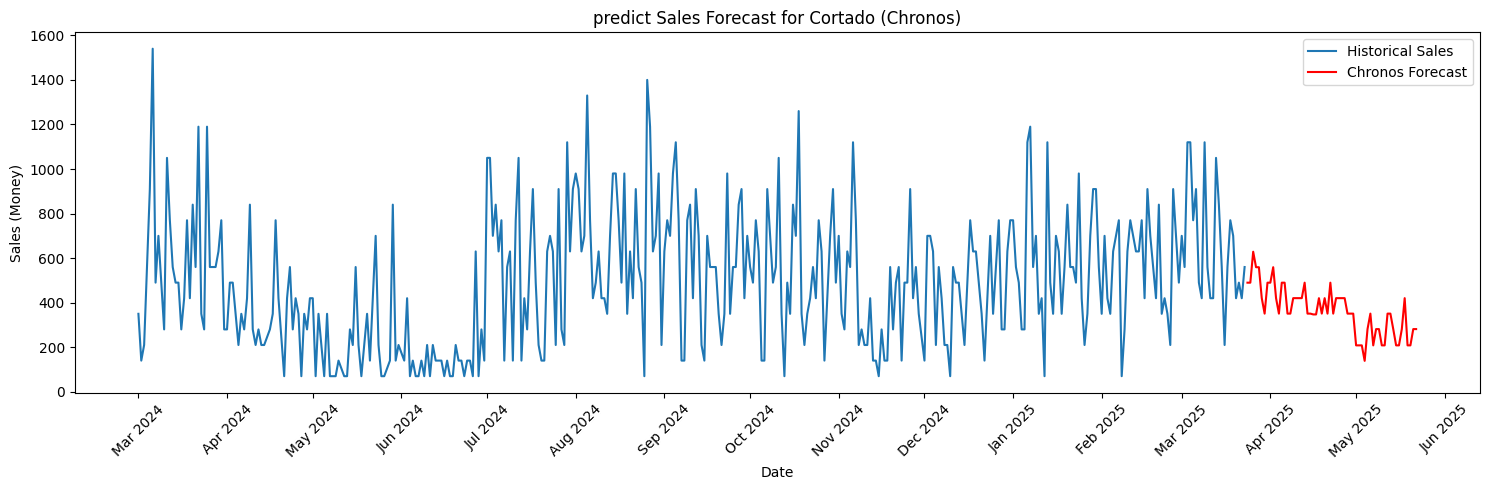

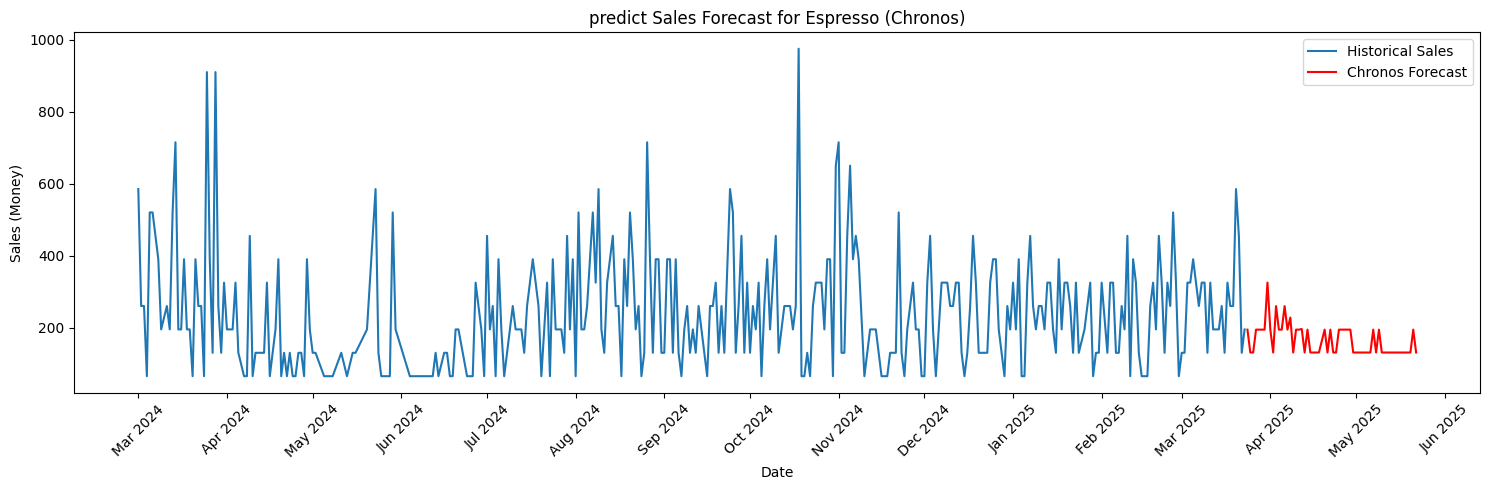

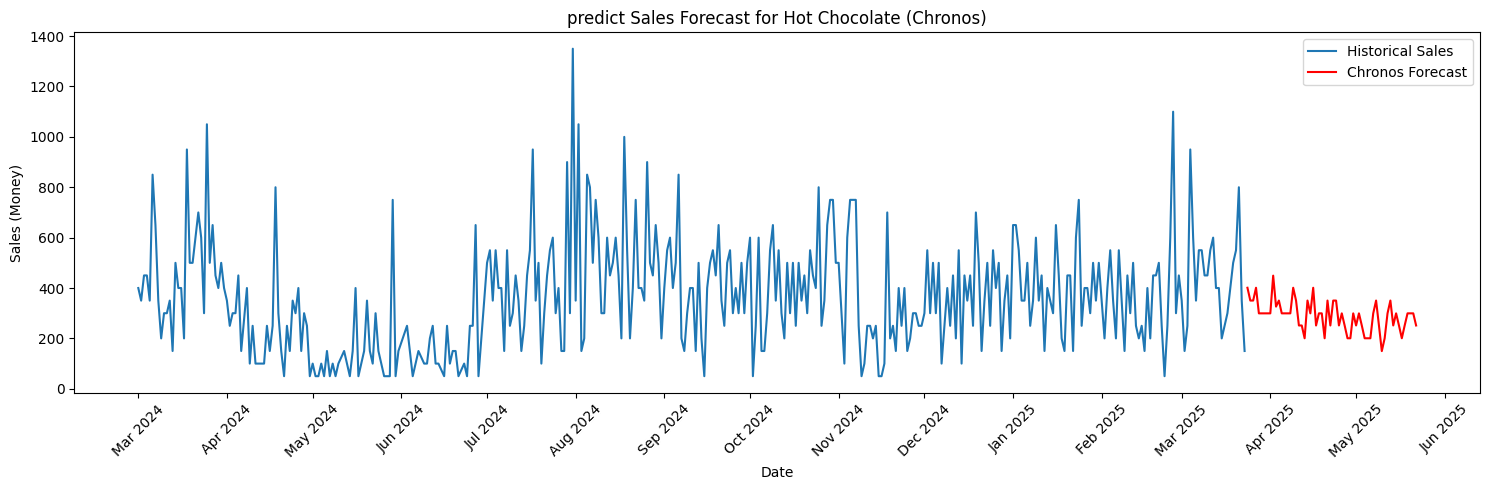

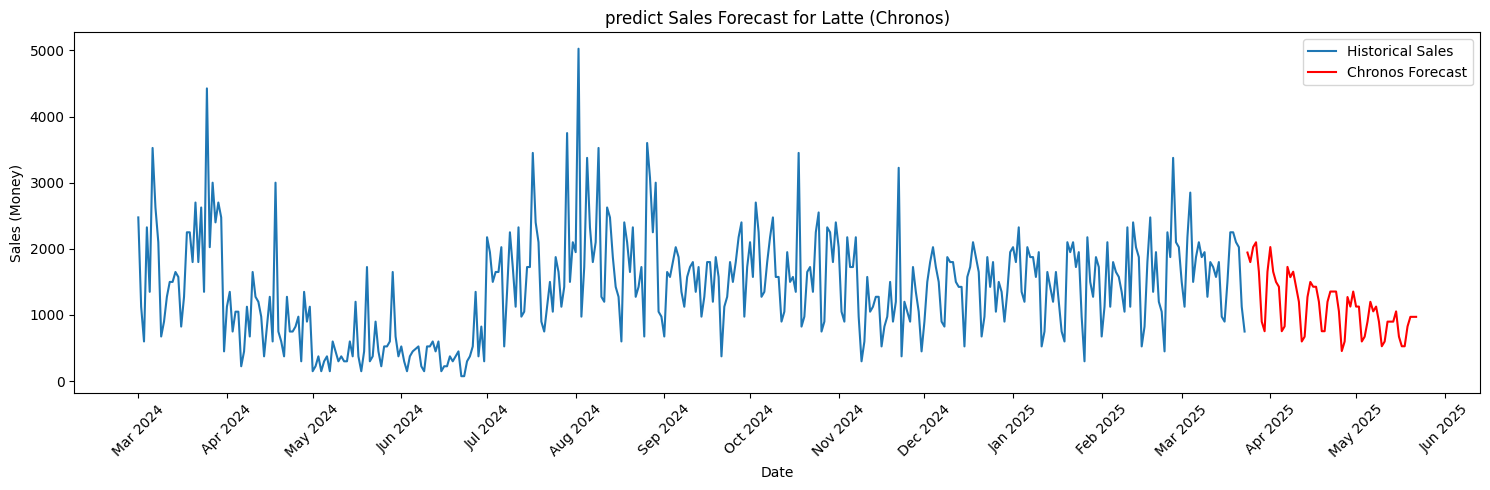

In [ ]:
coffee_forecasts = {}
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date_filter = '2024-03-01' # Assuming the user wants to start from March 1, 2024 for filtering
    end_date_filter = '2025-03-23'
    coffee_sales_filtered = coffee_sales[(coffee_sales['date'] >= start_date_filter) & (coffee_sales['date'] <= end_date_filter)].copy()


    context_data = coffee_sales_filtered['money'].values
    context = torch.tensor(context_data)


    prediction_length = 60

    forecast = pipeline.predict(context, prediction_length)


    median_prediction = forecast[0].median(dim=0).values

    coffee_forecasts[coffee_name] = median_prediction


    last_historical_date = coffee_sales_filtered['date'].max()
    forecast_start_date = last_historical_date + pd.Timedelta(days=1)


    forecast_dates = pd.date_range(start=forecast_start_date, periods=prediction_length, freq='D')


    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecasted_money': median_prediction})


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales_filtered['date'], coffee_sales_filtered['money'], label='Historical Sales')
    plt.plot(forecast_df['date'], forecast_df['forecasted_money'], label='Chronos Forecast', color='red')
    plt.title(f'predict Sales Forecast for {coffee_name} (Chronos)')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
forecast[0][:][0]

tensor([1799.2736, 2254.2625, 1654.5044, 2254.2625, 1799.2736, 1271.9004,
         599.7579, 2326.6470, 2026.7681, 1499.3948, 1271.9004, 1427.0101,
        1054.7466,  486.0107, 2171.5371, 1240.8784, 2099.1526, 1427.0101,
        1954.3834,  599.7579, 1127.1312, 1654.5044,  827.2523, 1199.5157,
        1054.7466,  899.6368,  827.2523,  754.8677,  672.1425,  972.0214,
         454.9888,  454.9888,  899.6368,  299.8790,  527.3733,  827.2523,
         372.2635,  299.8790,  899.6368,  527.3733,  599.7579,  155.1098,
         227.4944,  454.9888,  754.8677,  299.8790,  155.1098,  527.3733,
         155.1098,  454.9888,  372.2635,  454.9888,  227.4944,  227.4944,
         227.4944,  155.1098,  227.4944,  754.8677,  909.9775,  372.2635])

In [ ]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[2021.5977  1799.2736  2140.5151  2135.3447  1726.8889   899.6368
  754.86774 1690.6968  2026.7681  1654.5044  1535.587   1463.2024
  754.86774  827.2523  1726.8892  1613.1418  1690.6968  1427.0101
 1349.4553   635.9502   713.5051  1313.263   1499.3948  1427.0101
 1540.7573  1277.0707   791.06006  791.06006 1349.4553  1354.6256
 1354.6256  1354.6256  1090.939    491.18103  599.7579  1313.263
 1240.8784  1354.6256  1163.3235  1127.1312   635.9502   713.5051
 1013.38403 1220.197   1127.1311  1127.1312   935.8291   527.3733
  599.7579   935.8291   977.19165  935.8291  1163.3235   863.4445
  563.56555  599.7579   842.7633  1049.5763  1013.384   1013.384  ]
